In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation 
import time
import scipy as sp
import pyamg
from tqdm.notebook import tqdm

**A brief rundown on whats going on here The whole code is split into 3 parts; the solvers, initialization and postprocessing**

# Solvers
**Convective upwind schemes**  
* upwind1: 1st order upwind  
* TVD2: 2nd order total variation diminishing  
* QUICK3: 3rd order deferred QUICK  

**Functions**  
* mom: discretise NS eqns and solves them  
* face: calculate face velocities using Rhie & Chow interpolation  
* cont: set ups and solve the continuity eqn to get pressure correction  
* correct: correct the nodal velocities and pressure. (Would be nice if someone explain to me why face velocities need to
be corrected, even though here it is not done and this code is still able to get decently accurate results)  

# Initialization:
* Here you just set up the domain length, mesh sizes, relaxation factors, inlet velocities, time step size, steady or transient etc 
    
# Solution:
* Just solves the NS eqns, you can finetune the residual requirement
    
# Post-Processing:
* Colorful graphs or animations (reminder to run the %matplotlib notebook cell if want to play animations for transient flow)

    
# A bit more details on the mom solver:
* **Variables and their meanings:** 
    * b: aspect ratio, dy/dx (even though its there, the code can only run on square cells, has not been a major enough problem for me to find the error and solve it)
            
    * a1: eastern face flux from previous iteration
    * a2: western face flux from previous iteration
    * e1: northern face flux from previous iteration
    * e2: southern face flux from previous iteration
    * av1: implicit under-relaxation of systems of equations
    * av2: explicit under-relaxation for the velocity corrections  
            
* **Discretisation methods:**
    * Diffusion: 4th order central difference
    * Convection: Pick and choose (upwind1, QUICK3 and TVD2 is here, you can just find and replace the functions if you want to convert it)
    *Boundary cells: 3rd order forward/backward differencing
        
    * You will notice some lines of code that look like this (UWW=4*UW-6*UP+4*UE-UEE). They are just cubic extrapolations to create a ghost cell. As higher order schemes have a larger stencil, the cells next to boundary cells will need ghost cells to if you want to continue using 4th order CD for example. Moreover, you will notice I updated the source terms for such cells. This is due to the fact those ghost cells are just ficticious and solving them implicitly will result in index error. 
    
    * Time: You can choose either explicit 4th order Adams-Bashforth time-stepping or implicit 3rd order time stepping. You can set the Explicit=True/False to choose which time-stepping method to use
    
                                                    
**I hope this is enough to roughly understand what is going on. This code is by no means efficient but it gets the job done decently well.**

In [25]:
%matplotlib notebook

In [49]:
def upwind1(AE,AW,AN,AS,AP,uBP,vBP,ue,uw,vn,vs,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    
    AP+=b*(abs(ue)+ue)
    AE-=b*(abs(ue)-ue)

    AP+=b*(abs(uw)-uw)
    AW-=b*(abs(uw)+uw)

    AP+=(abs(vn)+vn)
    AN-=(abs(vn)-vn)

    AP+=(abs(vs)-vs)
    AS-=(abs(vs)+vs)
    
    return AE,AW,AN,AS,AP,uBP,vBP

In [50]:
def upwind2(AE,AW,AN,AS,AP,uBP,vBP,ue,uw,vn,vs,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    global b
    
    AP+=1.5*b*(abs(ue)+ue)
    defer=0.5*b*(abs(ue)+ue)*UE
    uBP+=defer
    vBP+=defer
    AE-=1.5*b*(abs(ue)-ue)
    defer=0.5*b*(abs(ue)-ue)*UEE
    uBP-=defer
    vBP-=defer

    AP+=1.5*b*(abs(uw)-uw)
    uBP+=0.5*b*(abs(uw)-uw)*UE
    uBP+=defer
    vBP+=defer
    AW-=1.5*b*(abs(uw)+uw)
    defer=0.5*b*(abs(uw)+uw)*UWW
    uBP-=defer
    vBP-=defer

    AP+=1.5*(abs(vn)+vn)
    defer=0.5*(abs(vn)+vn)*VS
    uBP+=defer
    vBP+=defer
    AN-=1.5*(abs(vn)-vn)
    defer=0.5*(abs(vn)-vn)*VNN
    uBP-=defer
    vBP-=defer

    AP+=1.5*(abs(vs)-vs)
    defer=0.5*(abs(vs)-vs)*VN
    uBP+=defer
    vBP+=defer
    AS-=1.5*(abs(vs)+vs)
    defer=0.5*(abs(vs)+vs)*VSS
    uBP-=defer
    vBP-=defer
            
    return AE,AW,AN,AS,AP,uBP,vBP

In [51]:
def TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    global b
    
    uBP0=uBP
    vBP0=vBP
    ue=a1
    uw=a2
    vn=e1
    vs=e2
    
    if ue!=0:
        if ue>0:
            AP+=2*a1*b
            
            r=(UP-UW)/(UE-UP)
            limit=(r+r**2)/(1+r**2)
            flux=(UE-UP)

            uBP-=a1*b*limit*flux
            vBP-=a1*b*limit*flux
        else:
            AE+=2*a1*b

            r=(UE-UEE)/(UP-UE)
            limit=(r+r**2)/(1+r**2)
            flux=(UP-UE)

            uBP-=a1*b*limit*flux
            vBP-=a1*b*limit*flux
    if uw!=0:
        if uw<0:
            AP-=2*a2*b

            r=(UP-UE)/(UW-UP)
            limit=(r+r**2)/(1+r**2)
            flux=(UW-UP)

            uBP+=a2*b*limit*flux
            vBP+=a2*b*limit*flux       
        else:
            AW-=2*a2*b

            r=(UW-UWW)/(UP-UW)
            limit=(r+r**2)/(1+r**2)
            flux=(UP-UW)

            uBP+=a2*b*limit*flux
            vBP+=a2*b*limit*flux
    if vn!=0:
        if vn>0:
            AP+=2*e1

            r=(VP-VS)/(VN-VP)
            limit=(r+r**2)/(1+r**2)
            flux=VN-VP
            
            uBP-=e1*limit*flux
            vBP-=e1*limit*flux
        else:
            AN+=2*e1

            r=(VN-VNN)/(VP-VN)
            limit=(r+r**2)/(1+r**2)
            flux=VP-VN

            uBP-=e1*limit*flux
            vBP-=e1*limit*flux
    if vs!=0:
        if vs<0:
            AP-=2*e2

            r=(VP-VN)/(VS-VP)
            limit=(r+r**2)/(1+r**2)
            flux=VS-VP
            
            uBP+=e2*limit*flux
            vBP+=e2*limit*flux
        else:
            AS-=2*e2

            r=(VS-VSS)/(VP-VS)
            limit=(r+r**2)/(1+r**2)
            flux=VP-VS

            uBP+=e2*limit*flux
            vBP+=e2*limit*flux

    if iter_total>1:
        return AE,AW,AN,AS,AP,uBP,vBP
    else:
        return AE,AW,AN,AS,AP,uBP0,vBP0

In [52]:
def QUICK3(AE,AW,AN,AS,AP,uBP,vBP,ue,uw,vn,vs,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP):
    global b

    if ue!=0:
        if ue>0:
            AP+=2*ue*b
            uBP-=ue*b*(3*UE-2*UP-UW)/4
            vBP-=ue*b*(3*UE-2*UP-UW)/4
        else:
            AE+=2*ue*b
            uBP-=ue*b*(3*UP-2*UE-UEE)/4
            vBP-=ue*b*(3*UP-2*UE-UEE)/4
    if uw!=0:
        if uw<0:
            AP-=2*uw*b
            uBP+=uw*b*(3*UW-2*UP-UE)/4
            vBP+=uw*b*(3*UW-2*UP-UE)/4
        else:
            AW-=2*uw*b
            uBP+=uw*b*(3*UP-2*UW-UWW)/4
            vBP+=uw*b*(3*UP-2*UW-UWW)/4
    if vn!=0:
        if vn>0:
            AP+=2*vn
            uBP-=vn*(3*VN-2*VP-VS)/4
            vBP-=vn*(3*VN-2*VP-VS)/4
        else:
            AN+=2*vn
            uBP-=vn*(3*VP-2*VN-VNN)/4
            vBP-=vn*(3*VP-2*VN-VNN)/4
    if vs!=0:
        if vs<0:
            AP-=2*vs
            uBP+=vs*(3*VS-2*VP-VN)/4
            vBP+=vs*(3*VS-2*VP-VN)/4
        else:
            AS-=2*vs
            uBP+=vs*(3*VP-2*VS-VSS)/4
            vBP+=vs*(3*VP-2*VS-VSS)/4

    return AE,AW,AN,AS,AP,uBP,vBP
    

In [88]:
def mom(Nx,Ny,U,V,P,U0,V0,time_step,UAB,VAB,U_old,V_old,U_older,V_older,av):
    global dx
    global dy
    global dt
    global v
    global u_wall
    global transient
    global Explicit
    
    N=Nx*Ny
    
    A=np.zeros([N,N])
    uB=np.zeros([N,1])
    vB=np.zeros([N,1])
    DX=np.zeros([N,1])
    DY=np.zeros([N,1])
    
    b=dy/dx
    y=v/dy
    x=v*b/dx
    k=dt/dy
    alpha=(1-av)/av
    
   
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            ij=i+Nx*j
            
            AEE=0
            AWW=0
            ANN=0
            ASS=0
            uBP=0
            vBP=0
            
            if j==1:
                VNN=V[j+2][i]
                VN=V[j+1][i]
                VP=V[j][i]
                VS=V[j-1][i]
                VSS=4*VS-6*VP+4*VN-VNN
                
                ASS=(1/12)*y*VSS
                uBP-=ASS
                vBP-=ASS
                
            elif j==Ny-2:
                VSS=V[j-2][i]
                VS=V[j-1][i]
                VP=V[j][i]
                VN=V[j+1][i]
                VNN=4*VN-6*VP+4*VS-VSS
                
                ANN=(1/12)*y*VNN
                uBP-=ANN
                vBP-=ANN
                
            else:
                VNN=V[j+2][i]
                VN=V[j+1][i]
                VP=V[j][i]
                VS=V[j-1][i]
                VSS=V[j-2][i]
                
                ASS=(1/12)*y
                ANN=(1/12)*y
                A[ij][ij-2*Nx]=ASS
                A[ij][ij+2*Nx]=ANN
                
            if i==1:
                UEE=U[j][i+2]
                UE=U[j][i+1]
                UP=U[j][i]
                UW=U[j][i-1]
                UWW=4*UW-6*UP+4*UE-UEE
                
                AWW=(1/12)*x*UWW
                uBP-=AWW
                vBP-=AWW
                
            elif i==Nx-2:
                UWW=U[j][i-2]
                UW=U[j][i-1]
                UP=U[j][i]
                UE=U[j][i+1]
                UEE=4*UE-6*UP+4*UW-UWW
                
                AEE=(1/12)*x*UEE
                uBP-=AEE
                vBP-=AEE
                
            else:
                UEE=U[j][i+2]
                UE=U[j][i+1]
                UP=U[j][i]
                UW=U[j][i-1]
                UWW=U[j][i-2]
                
                AEE=(1/12)*x
                AWW=(1/12)*x
                A[ij][ij+2]=AEE
                A[ij][ij-2]=AWW
                
            a1=(27*UP+27*UE-3*UW-3*UEE)/48
            a2=(27*UP+27*UW-3*UWW-3*UE)/48
            e1=(27*VP+27*VN-3*VS-3*VNN)/48
            e2=(27*VP+27*VS-3*VSS-3*VN)/48

            AE=-(7/3)*x
            AW=-(7/3)*x
            AN=-(7/3)*y
            AS=-(7/3)*y
            AP=4.5*x+4.5*y

            AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

            uBP+=b*(P[j][i-1]-P[j][i+1])+alpha*AP*UP
            vBP+=(P[j-1][i]-P[j+1][i])+alpha*AP*VP
                
            Dx=dy/AP
            Dy=dx/AP
           
            A[ij][ij-1]=AW
            A[ij][ij]=AP/av
            A[ij][ij+1]=AE
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            uB[ij]=uBP
            vB[ij]=vBP
            DX[ij]=Dx
            DY[ij]=Dy
            
    #for bottom wall
    for i in range(1,Nx-1):
        j=0
        ij=i+j*Nx
        
        AEE=0
        AWW=0
        ANN=0
        uBP=0
        vBP=0
        
        if i==1:
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UWW=4*UW-6*UP+4*UE-UEE
            
            AWW=(1/12)*x*UWW
            
            uBP-=AWW
            vBP-=AWW
            
        elif i==Nx-2:
            UW=U[j][i-1]
            UWW=U[j][i-2]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=4*UE-6*UP+4*UW-UWW
            
            AEE=(1/12)*x*UEE
            
            uBP-=AEE
            vBP-=AEE
            
        else:
            UWW=U[j][i-2]
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            
            AEE=(1/12)*x
            AWW=(1/12)*x
            
            A[ij][ij+2]=AEE
            A[ij][ij-2]=AWW
            
        VP=V[j][i]
        VN=V[j+1][i]
        VNN=V[j+2][i]
        VNNN=V[j+3][i]
        VS=4*VP-6*VN+4*VNN-VNNN

        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48

        AE=-(7/3)*x
        AW=-(7/3)*x
        AN=-4*y
        AP=9.75*y+4.5*x
        ANN=(23/60)*y

        AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

        uBP+=b*(P[j][i-1]-P[j][i+1])+alpha*AP*U[j][i]
        vBP+=(P[j][i]-P[j+1][i])+alpha*AP*V[j][i]
        Dx=dy/AP
        Dy=dx/AP

        A[ij][ij-1]=AW
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+Nx]=AN
        A[ij][ij+2*Nx]=ANN
        uB[ij]=uBP
        vB[ij]=vBP
        DX[ij]=Dx
        DY[ij]=Dy
    
    #for top wall
    for i in range(1,Nx-1):
        j=Ny-1
        ij=i+j*Nx
        
        AEE=0
        AWW=0
        uBP=0
        vBP=0
        
        if i==1:
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            UWW=4*UW-6*UP+4*UE-UEE
            
            AWW=(1/12)*x*UWW
            
            uBP-=AWW
            vBP-=AWW
            
        elif i==Nx-2:
            UWW=U[j][i-2]
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=4*UE-6*UP+4*UW-UWW
            
            AEE=(1/12)*x*UEE
            
            uBP-=AEE
            vBP-=AEE
            
        else:
            UWW=U[j][i-2]
            UW=U[j][i-1]
            UP=U[j][i]
            UE=U[j][i+1]
            UEE=U[j][i+2]
            
            AEE=(1/12)*x
            AWW=(1/12)*x
            
            A[ij][ij+2]=AEE
            A[ij][ij-2]=AWW
            
        
        VP=V[j][i]
        VS=V[j-1][i]
        VSS=V[j-2][i]
        VSSS=V[j-3][i]
        VN=4*VP-6*VS+4*VSS-VSSS

        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48

        AE=-(7/3)*x
        AW=-(7/3)*x
        AS=-4*y
        ASS=(23/60)*y
        AP=9.75*y+4.25*x
        
        AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,a2,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
        
        uBP+=b*(P[j][i-1]-P[j][i+1])+(92/15)*y*u_wall+alpha*AP*UP
        vBP+=(P[j-1][i]-P[j][i])+alpha*AP*VP            
        Dx=dy/AP
        Dy=dx/AP
            
        A[ij][ij-1]=AW
        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij-Nx]=AS
        A[ij][ij-2*Nx]=ASS
        uB[ij]=uBP
        vB[ij]=vBP
        DX[ij]=Dx
        DY[ij]=Dy
        
        
    #for left wall:
    for j in range(1,Ny-1):
        i=0
        ij=i+Nx*j
        
        ANN=0
        ASS=0
        uBP=0
        vBP=0
        
        if j==1:            
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            VSS=4*VS-6*VP+4*VN-VNN
            
            ASS=(1/12)*y*VSS
            
            uBP-=ASS
            vBP-=ASS
            
        elif j==Ny-2:            
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VSS=V[j-2][i]
            VNN=4*VN-6*VP+4*VS-VSS
            
            ANN=(1/12)*y*VNN
            
            uBP-=ANN
            vBP-=ANN

        else:
            VSS=V[j-2][i]
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            
            ANN=(1/12)*y
            ASS=(1/12)*y
            
            A[ij][ij+2*Nx]=ANN
            A[ij][ij-2*Nx]=ASS
            

        UP=U[j][i]
        UE=U[j][i+1]
        UEE=U[j][i+2]
        UEEE=U[j][i+3]
        UW=4*UP-6*UE+4*UEE-UEEE

        a1=(27*UP+27*UE-3*UW-3*UEE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48

        AE=-(11/3)*x
        AEE=(23/60)*x
        AN=-(7/3)*y
        AS=-(7/3)*y
        AP=9.75*x+4.5*y

        AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

        uBP+=b*(P[j][i]-P[j][i+1])+alpha*AP*UP
        vBP+=(P[j-1][i]-P[j+1][i])+alpha*AP*VP
        Dx=dy/AP
        Dy=dx/AP

        A[ij][ij]=AP/av
        A[ij][ij+1]=AE
        A[ij][ij+2]=AEE
        A[ij][ij-Nx]=AS
        A[ij][ij+Nx]=AN
        uB[ij]=uBP
        vB[ij]=vBP
        DX[ij]=Dx
        DY[ij]=Dy
    
    #for right wall:
    for j in range(1,Ny-1):
        i=Nx-1
        ij=i+Nx*j
        
        ANN=0
        ASS=0
        uBP=0
        vBP=0
        
        if j==1:
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            VSS=4*VS-6*VP+4*VN-VNN
            
            ASS=(1/12)*y*VSS
            
            uBP-=ASS
            vBP-=ASS
            
        elif j==Ny-2:
            VSS=V[j-2][i]
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VNN=4*VN-6*VP+4*VS-VSS
            
            ANN=(1/12)*y*VNN
            
            uBP-=ANN
            vBP-=ANN
        
        else:
            VSS=V[j-2][i]
            VS=V[j-1][i]
            VP=V[j][i]
            VN=V[j+1][i]
            VNN=V[j+2][i]
            
            ANN=(1/12)*y
            ASS=(1/12)*y
            
            A[ij][ij+2*Nx]=ANN
            A[ij][ij-2*Nx]=ASS
            
        UP=U[j][i]
        UW=U[j][i-1]
        UWW=U[j][i-2]
        UWWW=U[j][i-3]
        UE=4*UP-6*UW+4*UWW-UWW

        a2=(27*UP+27*UW-3*UWW-3*UE)/48
        e1=(27*VP+27*VN-3*VS-3*VNN)/48
        e2=(27*VP+27*VS-3*VSS-3*VN)/48

        AW=-4*x
        AWW=(23/60)*x
        AN=-(7/3)*y
        AS=-(7/3)*y
        AP=9.75*x+4.5*y

        AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,0,a2,e1,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)

        uBP+=b*(P[j][i-1]-P[j][i])+alpha*AP*UP
        vBP+=(P[j-1][i]-P[j+1][i])+alpha*AP*VP
        Dx=dy/AP
        Dy=dx/AP

        A[ij][ij]=AP/av
        A[ij][ij-1]=AW
        A[ij][ij-2]=AWW
        A[ij][ij-Nx]=AS
        A[ij][ij+Nx]=AN
        uB[ij]=uBP
        vB[ij]=vBP
        DX[ij]=Dx
        DY[ij]=Dy
        
    #top right cell
    i=Nx-1
    j=Ny-1
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UP=U[j][i]
    UW=U[j][i-1]
    UWW=U[j][i-2]
    UWWW=U[j][i-3]
    UE=4*UP-6*UW+4*UWW-UWWW

    VSSS=V[j-3][i]
    VSS=V[j-2][i]
    VS=V[j-1][i]
    VP=V[j][i]
    VN=4*VP-6*VS+4*VSS-VSSS

    a2=(27*UP+27*UW-3*UWW-3*UE)/48
    e2=(27*VP+27*VS-3*VSS-3*VN)/48
    
    AW=-4*x
    AWW=(23/60)*x
    AS=-4*y
    ASS=(23/60)*y
    AP=9.75*x+9.75*y
    
    AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,0,a2,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i-1]-P[j][i])+(92/15)*y*u_wall+alpha*AP*UP
    vBP+=(P[j-1][i]-P[j][i])+alpha*AP*VP
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij-1]=AW
    A[ij][ij-2]=AWW
    A[ij][ij-Nx]=AS
    A[ij][ij-2*Nx]=ASS
    uB[ij]=uBP
    vB[ij]=vBP
    DX[ij]=Dx
    DY[ij]=Dy
    
    #top left cell
    i=0
    j=Ny-1
    ij=i+Nx*j
    
    UP=U[j][i]
    UE=U[j][i+1]
    UEE=U[j][i+2]
    UEEE=U[j][i+3]
    UW=4*UP-6*UE+4*UEE-UEEE
    
    VSS=V[j-3][i]
    VSS=V[j-2][i]
    VS=V[j-1][i]
    VP=V[j][i]
    VN=4*VP-6*VS+4*VSS-VSSS

    a1=(27*UP+27*UE-3*UW-3*UEE)/48
    e2=(27*VP+27*VS-3*VSS-3*VN)/48
    
    AE=-4*x
    AEE=(23/60)*x
    AS=-4*y
    ASS=(23/60)*y
    AP=9.75*x+9.75*y

    AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,0,0,e2,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i]-P[j][i+1])+(92/15)*y*u_wall+alpha*AP*UP
    vBP+=(P[j-1][i]-P[j][i])+alpha*AP*VP
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij+1]=AE
    A[ij][ij+2]=AEE
    A[ij][ij-Nx]=AS
    A[ij][ij-2*Nx]=ASS
    uB[ij]=uBP
    vB[ij]=vBP
    DX[ij]=Dx
    DY[ij]=Dy
    
    #bottom right cell
    i=Nx-1
    j=0
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UWWW=U[j][i-3]
    UWW=U[j][i-2]
    UW=U[j][i-1]
    UP=U[j][i]
    UE=4*UP-6*UW+4*UWW-UWWW

    VP=V[j][i]
    VN=V[j+1][i]
    VNN=V[j+2][i]
    VNN=V[j+3][i]
    VS=4*VP-6*VN+4*VNN-VNNN

    a2=(27*UP+27*UW-3*UWW-3*UE)/48
    e1=(27*VP+27*VN-3*VS-3*VNN)/48
    
    AW=-4*x
    AWW=(23/60)*x
    AN=-4*y
    ANN=(23/60)*y
    AP=9.75*x+9.75*y

    AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,0,a2,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i-1]-P[j][i])+alpha*AP*UP
    vBP+=(P[j][i]-P[j+1][i])+alpha*AP*VP
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij-1]=AW
    A[ij][ij-2]=AWW
    A[ij][ij+Nx]=AN
    A[ij][ij+2*Nx]=ANN
    uB[ij]=uBP
    vB[ij]=vBP
    DX[ij]=Dx
    DY[ij]=Dy
    
    #bottom left cell
    i=0
    j=0
    ij=i+Nx*j
    
    uBP=0
    vBP=0
    
    UP=U[j][i]
    UE=U[j][i+1]
    UEE=U[j][i+2]
    UEEE=U[j][i+3]
    UW=4*UP-6*UW+4*UWW-UWWW

    VP=V[j][i]
    VN=V[j+1][i]
    VNN=V[j+2][i]
    VNN=V[j+3][i]

    a1=(27*UP+27*UE-3*UW-3*UEE)/48
    e1=(27*VP+27*VN-3*VS-3*VNN)/48
    
    AE=-4*x
    AEE=(23/60)*x
    AN=-4*y
    ANN=(23/60)*y
    AP=9.75*x+9.75*y
    
    AE,AW,AN,AS,AP,uBP,vBP=TVD2(AE,AW,AN,AS,AP,uBP,vBP,a1,0,e1,0,UE,UW,UEE,UWW,UP,VN,VS,VNN,VSS,VP)
    
    uBP+=b*(P[j][i]-P[j][i+1])+alpha*AP*UP
    vBP+=(P[j][i]-P[j+1][i])+alpha*AP*VP
    Dx=dy/AP
    Dy=dx/AP
    
    A[ij][ij]=AP/av
    A[ij][ij+1]=AE
    A[ij][ij+2]=AEE
    A[ij][ij+Nx]=AN
    A[ij][ij+2*Nx]=ANN
    uB[ij]=uBP
    vB[ij]=vBP
    DX[ij]=Dx
    DY[ij]=Dy    
    
    if transient==True:
        if Explicit==True:
        #Explicit
            At=-k*A
            uBt=k*uB
            vBt=k*vB

            if time_step==1:
                Un=order_1(At,uBt,U,U0,N,UAB)
                Vn=order_1(At,vBt,V,V0,N,VAB)
            elif time_step==2:
                Un=order_2(At,uBt,U,U0,N,UAB)
                Vn=order_2(At,vBt,U,V0,N,VAB)
            elif time_step==3:
                Un=order_3(At,uBt,U,U0,N,UAB)
                Vn=order_3(At,vBt,U,V0,N,VAB)
            else:
                Un=order_4(At,uBt,U,U0,N,UAB)
                Vn=order_4(At,vBt,U,V0,N,VAB)

        else: 
            #Implicit
            k=dy/dt

            for j in range(Ny):
                for i in range(Nx):
                    ij=i+Nx*j

                    if time_step==1:
                    #1st order implicit
                        A[ij][ij]+=k
                        uB[ij]+=k*U0[j][i]
                        vB[ij]+=k*V0[j][i]
                    elif time_step==2:
                    #2nd order implicit
                        A[ij][ij]+=1.5*k
                        uB[ij]+=k*(2*U0[j][i]-0.5*U_old[j][i])
                        vB[ij]+=k*(2*V0[j][i]-0.5*V_old[j][i])
                    else:
                    #3rd order implicit
                        A[ij][ij]+=(11/6)*k
                        uB[ij]+=k*(18*U0[j][i]-9*U_old[j][i]+2*U_older[j][i])/6
                        vB[ij]+=k*(18*V0[j][i]-9*V_old[j][i]+2*V_older[j][i])/6

            A=sp.sparse.csr_matrix(A)
            ml=pyamg.ruge_stuben_solver(A)
            Un=ml.solve(uB,tol=1E-6)
            Vn=ml.solve(vB,tol=1E-6)

            At=0
            uBt=0
            vBt=0
    
        U_mesh=np.reshape(np.array(Un),[Ny,Nx])
        V_mesh=np.reshape(np.array(Vn),[Ny,Nx])
        DX_mesh=np.reshape(np.array(DX),[Ny,Nx])
        DY_mesh=np.reshape(np.array(DY),[Ny,Nx])

        return U_mesh,V_mesh,DX_mesh,DY_mesh,At,uBt,vBt
    
    else:
        A=sp.sparse.csr_matrix(A)
        ml=pyamg.ruge_stuben_solver(A)
        U=ml.solve(uB,tol=1E-6)
        V=ml.solve(vB,tol=1E-6)

        U_mesh=np.reshape(np.array(U),[Ny,Nx])
        V_mesh=np.reshape(np.array(V),[Ny,Nx])
        DX_mesh=np.reshape(np.array(DX),[Ny,Nx])
        DY_mesh=np.reshape(np.array(DY),[Ny,Nx])

        return U_mesh,V_mesh,DX_mesh,DY_mesh

In [89]:
def face(Uf,Vf,U,V,P_mesh,uNx,uNy,vNx,vNy,DX,DY):
    #U-faces
    DXf=np.zeros([uNy,uNx])
    for j in range(uNy):
        for i in range(2,uNx-2):
            ij=i+Nx*j
            
            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P_mesh[j][i-2]-P_mesh[j][i])
            PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])
  
            dp=(DP+DE)/2
            Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
            Pf=(-(PP+PE)/2)+Pp
            
            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp
            
    for j in range(uNy):
        i=1
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P_mesh[j][i-1]-P_mesh[j][i])
        PE=DE*(P_mesh[j][i-1]-P_mesh[j][i+1])

        dp=(DP+DE)/2
        Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
        
        i=uNx-2
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P_mesh[j][i-2]-P_mesh[j][i])
        PE=DE*(P_mesh[j][i-1]-P_mesh[j][i])

        dp=(DP+DE)/2
        Pp=dp*(P_mesh[j][i-1]-P_mesh[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
          
    #V-faces    
    DYf=np.zeros([vNy,vNx])
    for j in range(2,vNy-2):
        for i in range(vNx):
            ij=i+Nx*j
            
            VN=V[j][i]
            VP=V[j-1][i]
            Ve=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P_mesh[j-2][i]-P_mesh[j][i])
            PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])
  
            dp=(DP+DN)/2
            Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
            Pf=(-(PP+PN)/2)+Pp
            
            vf=Ve+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp
            
    for i in range(vNx):
        j=1
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P_mesh[j-1][i]-P_mesh[j][i])
        PN=DN*(P_mesh[j-1][i]-P_mesh[j+1][i])

        dp=(DP+DN)/2
        Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        
        j=vNy-2
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P_mesh[j-2][i]-P_mesh[j][i])
        PN=DN*(P_mesh[j-1][i]-P_mesh[j][i])

        dp=(DP+DN)/2
        Pp=dp*(P_mesh[j-1][i]-P_mesh[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        
    return Uf,Vf,DXf,DYf

In [90]:
def cont(Nx,Ny,U,V,P,DX,DY):
    global b
    global u_wall

    N=Nx*Ny
    
    A=np.zeros([N,N])
    B=np.zeros([N,1])
    
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            ij=i+Nx*j
     
            ue=U[j][i+1]
            uw=U[j][i]
            vn=V[j+1][i]
            vs=V[j][i]
            
            AE=-b*DX[j][i+1]
            AW=-b*DX[j][i]
            AN=-DY[j+1][i]
            AS=-DY[j][i]
            AP=-AE-AW-AN-AS
            BP=b*(uw-ue)+vs-vn
            
            A[ij][ij-1]=AW
            A[ij][ij+1]=AE
            A[ij][ij]=AP
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
    
    #left and right wall
    for j in range(1,Ny-1):
        i=0
        ij=i+Nx*j
        
        ue=U[j][i+1]
        vn=V[j+1][i]
        vs=V[j][i]

        AE=-b*DX[j][i+1]
        AN=-DY[j+1][i]
        AS=-DY[j][i]
        AP=-AE-AN-AS
        BP=b*(-ue)+vs-vn

        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        A[ij][ij-Nx]=AS
        B[ij]=BP
        
        i=Nx-1
        ij=i+Nx*j
        
        uw=U[j][i]
        vn=V[j+1][i]
        vs=V[j][i]

        AW=-b*DX[j][i]
        AN=-DY[j+1][i]
        AS=-DY[j][i]
        AP=-AW-AN-AS
        BP=b*(uw)+vs-vn

        A[ij][ij-1]=AW
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        A[ij][ij-Nx]=AS
        B[ij]=BP
    
    #for top and bottom wall
    for i in range(1,Nx-1):
        j=0
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vn=V[j+1][i]

        AE=-b*DX[j][i+1]
        AW=-b*DX[j][i]
        AN=-DY[j+1][i]
        AP=-AE-AW-AN
        BP=b*(uw-ue)-vn

        A[ij][ij-1]=AW
        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij+Nx]=AN
        B[ij]=BP
        
        j=Ny-1
        ij=i+Nx*j
        
        ue=U[j][i+1]
        uw=U[j][i]
        vs=V[j][i]

        AE=-b*DX[j][i+1]
        AW=-b*DX[j][i]
        AS=-DY[j][i]
        AP=-AE-AW-AS
        BP=b*(uw-ue)+vs

        A[ij][ij-1]=AW
        A[ij][ij+1]=AE
        A[ij][ij]=AP
        A[ij][ij-Nx]=AS
        B[ij]=BP
        
    #for top left corner
    i=0
    j=Ny-1
    ij=i+Nx*j
    
    ue=U[j][i+1]
    vs=V[j][i]

    AE=-b*DX[j][i+1]
    AS=-DY[j][i]
    AP=-AE-AS
    BP=b*(-ue)+vs

    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij-Nx]=AS
    B[ij]=BP
    
    #for top right corner
    i=Nx-1
    j=Ny-1
    ij=i+Nx*j
    
    uw=U[j][i]
    vs=V[j][i]

    AW=-b*DX[j][i]
    AS=-DY[j][i]
    AP=-AW-AS
    BP=b*(uw)+vs

    A[ij][ij-1]=AW
    A[ij][ij]=AP
    A[ij][ij-Nx]=AS
    B[ij]=BP
    
    #for bottom left corner
    i=0
    j=0
    ij=0
    
    ue=U[j][i+1]
    vn=V[j+1][i]

    AE=-b*DX[j][i+1]
    AN=-DY[j+1][i]
    AP=-AE-AN
    BP=b*(-ue)-vn

    A[ij][ij+1]=AE
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    B[ij]=BP
    
    #for bottom right corner
    i=Nx-1
    j=0
    ij=i+Nx*j
    
    uw=U[j][i]
    vn=V[j+1][i]

    AW=-b*DX[j][i]
    AN=-DY[j+1][i]
    AP=-AW-AN
    BP=b*(uw)-vn

    A[ij][ij-1]=AW
    A[ij][ij]=AP
    A[ij][ij+Nx]=AN
    B[ij]=BP
        
    A=sp.sparse.csr_matrix(A)
    ml=pyamg.ruge_stuben_solver(A)
    PC=ml.solve(B,tol=1E-6)
    
    PC_mesh=np.reshape(np.array(PC),[Ny,Nx])
    
    return PC_mesh,B

In [91]:
def correct(Nx,Ny,U_mesh,V_mesh,P_mesh,PC_mesh,DX,DY,av,ap):
    
    #U correction
    for j in range(Ny):
        for i in range(1,Nx-1):
            uc=av*DX[j][i]*(PC_mesh[j][i-1]-PC_mesh[j][i+1])
            U_mesh[j][i]=uc+U_mesh[j][i]
            
    for j in range(Ny):
        i=0
        uc=av*DX[j][i]*(PC_mesh[j][i]-PC_mesh[j][i+1])
        U_mesh[j][i]=uc+U_mesh[j][i]
        
        i=Nx-1
        uc=av*DX[j][i]*(PC_mesh[j][i-1]-PC_mesh[j][i])
        U_mesh[j][i]=uc+U_mesh[j][i]

    #V correction
    for j in range(1,Ny-1):
        for i in range(Nx):
            vc=av*DY[j][i]*(PC_mesh[j-1][i]-PC_mesh[j+1][i])
            V_mesh[j][i]=vc+V_mesh[j][i]
            
    for i in range(Nx):
        j=0
        vc=av*DY[j][i]*(PC_mesh[j][i]-PC_mesh[j+1][i])
        V_mesh[j][i]=vc+V_mesh[j][i]
        
        j=Ny-1
        vc=av*DY[j][i]*(PC_mesh[j-1][i]-PC_mesh[j][i])
        V_mesh[j][i]=vc+V_mesh[j][i]
    
    #P correction
    for j in range(Ny):
        for i in range(Nx):
            P_mesh[j][i]=P_mesh[j][i]+ap*PC_mesh[j][i]
        
    return U_mesh,V_mesh,P_mesh

In [92]:
def curl(U,V,dx,dy,Nx,Ny):
    C=np.zeros([Ny,Nx])
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            dvdx=(V[j+1][i]-V[j-1][i])/(2*dx)
            dxdy=(U[j][i+1]-U[j][i-1])/(2*dy) 
            C[j][i]=dvdx-dxdy
            
    return C

In [93]:
def order_1(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    y1=y0+fn
    return y1

In [94]:
def order_2(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-1]
    y2=y0+1.5*fn1-0.5*fn
    return y2

In [95]:
def order_3(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-2]
    fn2=AB[-1]
    y3=y0+(23*fn2-16*fn1+5*fn)/12
    return y3

In [96]:
def order_4(A0,B0,y,y0,N,AB):
    y0=np.reshape(y0,[N,1])
    fn=np.matmul(A0,np.reshape(y,[N,1]))+B0
    fn1=AB[-3]
    fn2=AB[-2]
    fn3=AB[-1]
    y4=y0+(55*fn3-59*fn2+37*fn1-9*fn)/24
    return y4

In [97]:
def curl(U,V,dx,dy,Nx,Ny):
    C=np.zeros([Ny,Nx])
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            dvdx=(V[j+1][i]-V[j-1][i])/(2*dx)
            dxdy=(U[j][i+1]-U[j][i-1])/(2*dy) 
            C[j][i]=dvdx-dxdy
            
    return C

In [98]:
def round_off(x):
    return float(('{:g}'.format(float('{:.5g}'.format(x)))))

# <font color='blue'>Initialisation</font>

In [99]:
transient=False
Explicit=True
u_wall=0.1
L=1
H=1
v=0.001
Re=abs(u_wall*L/v) 
av1=0.8 #Implicit under-relaxation
av2=0.7 #Explicit under-relaxation
ap=5E-3

Nx=48 #Array size for nodal velocities/pressure
Ny=48
N=Nx*Ny
uNx=Nx+1 #Array size for calculating face velocities
uNy=Ny
vNx=Nx
vNy=Ny+1

dx=L/Nx
dy=H/Ny
b=dy/dx
iter_count=1
iter_total=0
itermax=500

dt=5E-3
end_time=30
flow_time=0
time_step=0
time_steps=end_time/dt

U_data=[]
V_data=[]
U_time_data=[]
V_time_data=[]
U_res_list=[]
V_res_list=[]
Cont_res_list=[]
t_list=[]
UAB=[]
VAB=[]

U_mesh=np.zeros([Ny,Nx])
Uf=np.zeros([uNy,uNx])
V_mesh=np.zeros([Ny,Nx])
Vf=np.zeros([vNy,vNx])
P_mesh=np.zeros([Ny,Nx])
U_old=U_mesh
V_old=V_mesh
U_older=U_mesh
V_older=V_mesh

print('CFL:',round(u_wall*dt/dx,3))

CFL: 0.024


# <font color='blue'>Solution</font>

In [100]:
st=time.time()

if transient==True:
    print('Calculation Data')
    print('Number of cells:',N)
    print('Aspect Ratio:', round(b,4))
    print('Explicit relaxation factor:',av2)
    print('Implicit relaxation factor:',av1)
    print('Pressure relaxation factor:',ap)
    print('Total time steps:',int(time_steps))
    print()
    print("Reynold's Number:",Re)
    print()

    U0_mesh=U_mesh
    V0_mesh=V_mesh
    P0_mesh=P_mesh
    
    for flow in tqdm(range(int(time_steps)),desc='Progress bar',unit=' time steps '):
        if time_step==0:
            print()
            print('{:<10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format('Time Step','Iterations','U Residual','V Residual',
                                                            'Cont Residual','Time(s)'))
            print('=========================================================================================')

        s=time.time()
        if flow%100==0:
            U_time_data.append(U0_mesh)
            V_time_data.append(V0_mesh)

        iter_count=1
        time_step+=1
        flow_time+=dt

        while iter_count<=itermax:
            start=time.time()
            U1_mesh,V1_mesh,DX,DY,A,UB,VB=mom(Nx,Ny,U_mesh,V_mesh,P_mesh,U0_mesh,V0_mesh,time_step,UAB,VAB,U_old,V_old,U_older,V_older,av1)
            Uf,Vf,DXf,DYf=face(Uf,Vf,U1_mesh,V1_mesh,P_mesh,uNx,uNy,vNx,vNy,DX,DY)
            PC_mesh,cont_A=cont(Nx,Ny,Uf,Vf,P_mesh,DXf,DYf)
            U2_mesh,V2_mesh,P1_mesh=correct(Nx,Ny,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av2,ap)
            Uf,Vf,DXf,DYf=face(Uf,Vf,U2_mesh,V2_mesh,P1_mesh,uNx,uNy,vNx,vNy,DX,DY)
            PC_mesh,cont_B=cont(Nx,Ny,Uf,Vf,P1_mesh,DXf,DYf)
            U3_mesh,V3_mesh,P2_mesh=correct(Nx,Ny,U2_mesh,V2_mesh,P1_mesh,PC_mesh,DX,DY,av2,ap)

            U_residual=abs(max(U3_mesh.flatten()-U_mesh.flatten()))/u_wall
            U_res_list.append(abs(U_residual))
            V_residual=abs(max(V3_mesh.flatten()-V_mesh.flatten()))/u_wall
            V_res_list.append(abs(V_residual))
            P_residual=np.sum(abs(cont_B)/u_wall)
            Cont_res_list.append(P_residual)

            U_mesh=U3_mesh
            V_mesh=V3_mesh
            P_mesh=P2_mesh

            end=time.time()
            t=end-start
            t_list.append(t)

            U_residual=round_off(U_residual)
            V_residual=round_off(V_residual)
            P_residual=round_off(P_residual)

            if iter_count==1:
                print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                                 abs(V_residual),abs(P_residual),
                                                                 str(round(t,4))))

            if abs(U_residual)<1E-3 and abs(V_residual)<1E-3 and abs(P_residual)<1E-3:
                if time_step>1:
                    U_older=U_old
                    V_older=V_old

                U_old=U0_mesh
                V_old=V0_mesh
                U0_mesh=U_mesh
                V0_mesh=V_mesh
                P0_mesh=P_mesh
                iter_total+=1

                if Explicit==True:
                    grad_U=np.matmul(A,np.reshape(U0_mesh,[N,1]))+UB
                    UAB.append(grad_U)

                    grad_V=np.matmul(A,np.reshape(V0_mesh,[N,1]))+VB
                    VAB.append(grad_V)

                    if len(UAB)>3:
                        UAB.pop(0)
                        VAB.pop(0)

                break

            if iter_count==itermax:
                if time_step>1:
                    U_older=U_old
                    V_older=V_old

                U_old=U0_mesh
                V_old=V0_mesh
                U0_mesh=U_mesh
                V0_mesh=V_mesh
                P0_mesh=P_mesh
                iter_total+=1

                if Explicit==True:
                    grad_U=np.matmul(A,np.reshape(U0_mesh,[N,1]))+UB
                    UAB.append(grad_U)

                    grad_V=np.matmul(A,np.reshape(V0_mesh,[N,1]))+VB
                    VAB.append(grad_V)

                    if len(UAB)>3:
                        UAB.pop(0)
                        VAB.pop(0)
                break

            iter_count+=1
            iter_total+=1

        e=time.time()
        elap=e-s
        if iter_count!=1:
            print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                                 abs(V_residual),abs(P_residual),
                                                                 str(round(elap,4))))
            print()

        if abs(U_residual)<1E-7 and abs(V_residual)<1E-7 and iter_count==1:
            break

    U_final=U0_mesh
    V_final=V0_mesh

    et=time.time()
    elapsed=et-st
    print()
    print('Execution time:',round(elapsed,3),'seconds')
    print('Number of iterations:',iter_total)
    print('Average time per iteration:',round(np.mean(t_list),4),'+-',round(np.std(t_list),4),'seconds')
    print('Flow time:',round(flow_time,4),'seconds')
    
else:
    U_old=0
    V_old=0
    U_older=0
    V_older=0
    
    print('Calculation Data')
    print('Number of cells:',N)
    print('Aspect Ratio:', round(b,4))
    print('Explicit relaxation factor:',av2)
    print('Implicit relaxation factor:',av1)
    print('Pressure relaxation factor:',ap)
    print()
    print("Reynold's Number:",Re)
    print()
    print('{:<10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(' Iteration','U Residual','V Residual','Cont Residual','Time(s)'))
    print('=============================================================================')
    
    iter_total=1
    
    while iter_total<=itermax:
        start=time.time()
        U1_mesh,V1_mesh,DX,DY=mom(Nx,Ny,U_mesh,V_mesh,P_mesh,U0_mesh,V0_mesh,time_step,UAB,VAB,U_old,V_old,U_older,V_older,av1)
        Uf,Vf,DXf,DYf=face(Uf,Vf,U1_mesh,V1_mesh,P_mesh,uNx,uNy,vNx,vNy,DX,DY)
        PC_mesh,cont_A=cont(Nx,Ny,Uf,Vf,P_mesh,DXf,DYf)
        U2_mesh,V2_mesh,P1_mesh=correct(Nx,Ny,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av2,ap)
        Uf,Vf,DXf,DYf=face(Uf,Vf,U2_mesh,V2_mesh,P1_mesh,uNx,uNy,vNx,vNy,DX,DY)
        PC_mesh,cont_B=cont(Nx,Ny,Uf,Vf,P1_mesh,DXf,DYf)
        U3_mesh,V3_mesh,P2_mesh=correct(Nx,Ny,U2_mesh,V2_mesh,P1_mesh,PC_mesh,DX,DY,av2,ap)

        U_residual=abs(max(U3_mesh.flatten()-U_mesh.flatten()))/u_wall
        U_res_list.append(abs(U_residual))
        V_residual=abs(max(V3_mesh.flatten()-V_mesh.flatten()))/u_wall
        V_res_list.append(abs(V_residual))
        P_residual=np.sum(abs(cont_B)/u_wall)
        Cont_res_list.append(P_residual)

        if iter_count%5==0:
            U_data.append(U3_mesh)
            V_data.append(V3_mesh)

        U_mesh=U3_mesh
        V_mesh=V3_mesh
        P_mesh=P2_mesh

        end=time.time()
        t=end-start
        t_list.append(t)

        U_residual=round_off(U_residual)
        V_residual=round_off(V_residual)
        P_residual=round_off(P_residual)

        if iter_total%20==0 or iter_total<=10:
            print('{:^10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(str(iter_total),abs(U_residual),abs(V_residual),
                                                              abs(P_residual),str(round(t,4))))

        if abs(U_residual)<1E-4 and abs(V_residual)<1E-4 and abs(P_residual)<1E-3: 
            print('{:^10} |{:^18}|{:^18}|{:^18}|{:^9}'.format(str(iter_total),abs(U_residual),abs(V_residual),
                                                              abs(P_residual),str(round(t,4))))
            break

        if iter_total==itermax:
            break

        iter_total+=1

    U_final=U_mesh
    V_final=V_mesh

    et=time.time()
    elapsed=et-st
    print()
    print('Execution time:',round(elapsed,3),'seconds')
    print('Number of iterations:',iter_total)
    print('Average time per iteration:',round(np.mean(t_list),4),'+-',round(np.std(t_list),4),'seconds')

Calculation Data
Number of cells: 2304
Aspect Ratio: 1.0
Explicit relaxation factor: 0.7
Implicit relaxation factor: 0.8
Pressure relaxation factor: 0.005

Reynold's Number: 100.0

 Iteration |    U Residual    |    V Residual    |  Cont Residual   | Time(s) 
    1      |     0.51439      |      0.304       |      1.1105      | 0.3306  
    2      |     0.18145      |     0.093858     |      1.1523      | 0.3782  
    3      |     0.10712      |     0.053108     |     0.85445      | 0.3638  
    4      |     0.076285     |     0.027391     |     0.64821      | 0.4411  
    5      |     0.055269     |     0.019676     |     0.55199      | 0.3716  
    6      |     0.046138     |     0.01582      |     0.49174      |  0.393  
    7      |     0.039336     |     0.012882     |     0.44412      | 0.3471  
    8      |     0.033848     |     0.010794     |     0.40317      | 0.3451  
    9      |     0.029341     |    0.0092893     |     0.36876      | 0.3685  
    10     |     0.026345    

# <font color='blue'>Post-Processing</font>

In [82]:
U_final=U_mesh
V_final=V_mesh
P_final=P_mesh

In [101]:
V_mag=np.zeros([Ny,Nx])
for j in range(Ny):
    for i in range(Nx):
        V_mag[j][i]=(np.sqrt(np.power(U_final[j][i],2))+np.sqrt(np.power(V_final[j][i],2)))
        
vort=curl(U_final,V_final,dx,dy,Nx,Ny)

x=np.linspace(dx/2,L-dx/2,Nx)
y=np.linspace(dy/2,L-dy/2,Ny)
xx,yy=np.meshgrid(x,y)

xe=np.linspace(1,Nx,Nx)
ye=np.linspace(1,Ny,Ny)
xxe,yye=np.meshgrid(xe,ye)
grid=np.zeros([Ny,Nx])

C:\Users\Kangluo See\anaconda3\lib\site-packages\matplotlib\patches.py:3027: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


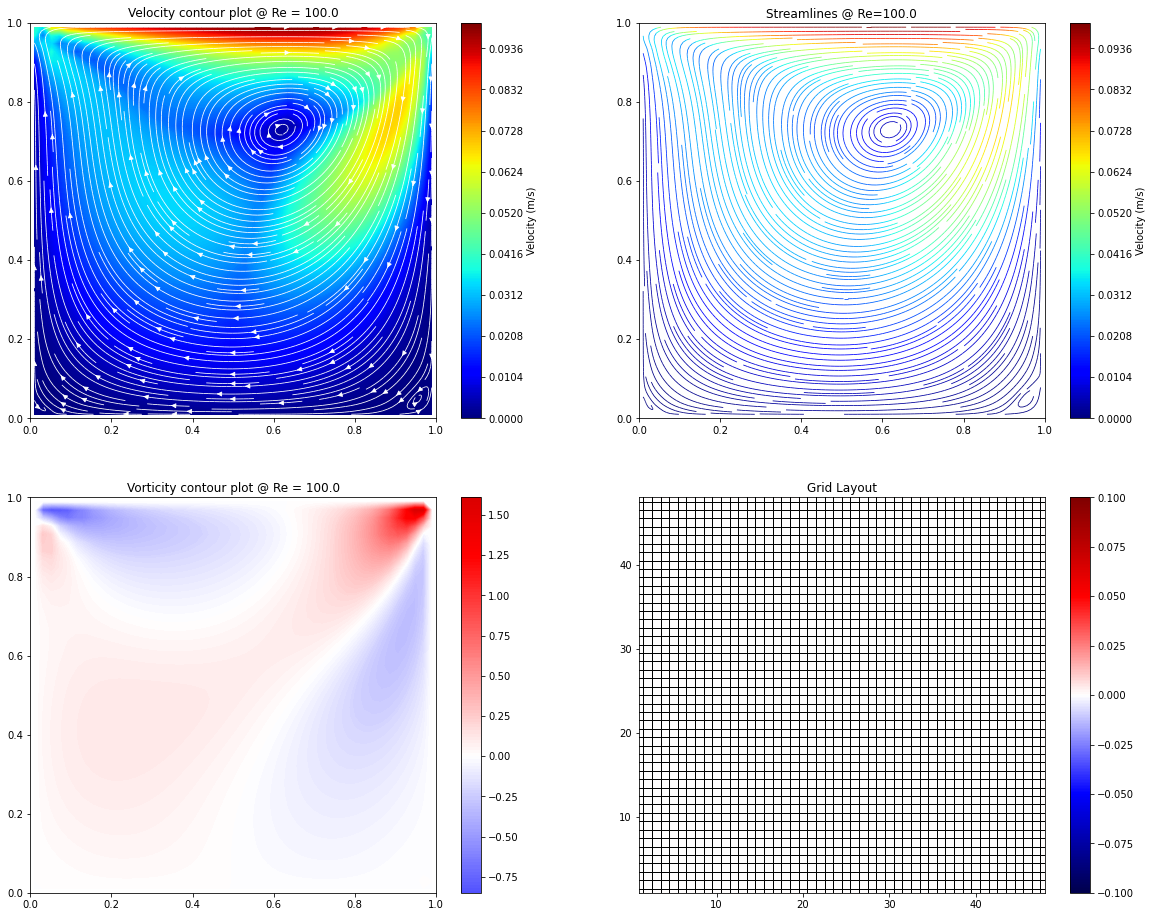

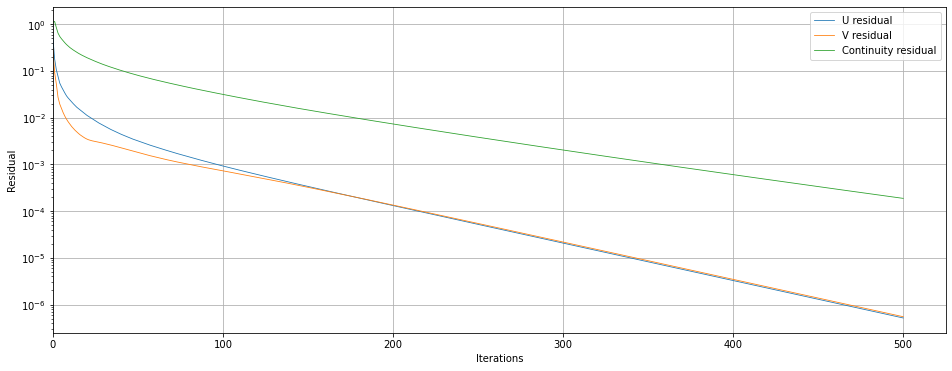

In [102]:
fig,ax=plt.subplots(2,2,figsize=(20,16))
ax[0][0].streamplot(xx,yy,U_final,V_final,density=2.5,color='white',linewidth=0.8)
graph=ax[0][0].contourf(xx,yy,V_mag,cmap=cm.jet,levels=255,vmax=u_wall)
ax[0][0].set_title('Velocity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[0][0],label='Velocity (m/s)')
ax[0][0].set_xlim(0,L)
ax[0][0].set_ylim(0,H)

ax[0][1].streamplot(xx,yy,U_final,V_final,density=3,color=V_mag,cmap=cm.jet,linewidth=0.8,arrowsize=0)
ax[0][1].set_title('Streamlines @ Re='+str(Re))
fig.colorbar(graph,ax=ax[0][1],label='Velocity (m/s)')
ax[0][1].set_xlim(0,L)
ax[0][1].set_ylim(0,H)

graph=ax[1][0].contourf(xx,yy,vort,cmap=cm.seismic,levels=255,vmax=2.5,vmin=-2.5)
ax[1][0].set_title('Vorticity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[1][0])
ax[1][0].set_xlim(0,L)
ax[1][0].set_ylim(0,H)

graph=ax[1][1].pcolormesh(xxe,yye,grid,cmap=cm.seismic,ec='k',shading='auto')
fig.colorbar(graph,ax=ax[1][1])
ax[1][1].set_title('Grid Layout')
ax[1][1].set_xlim(1,Nx)
ax[1][1].set_ylim(1,Ny)

plt.show()

iterations=np.linspace(0,iter_total,iter_total)
fig,ax=plt.subplots(1,1,figsize=(16,6))
plt.plot(iterations,U_res_list,label='U residual',linewidth=0.8)
plt.plot(iterations,V_res_list,label='V residual',linewidth=0.8)
plt.plot(iterations,Cont_res_list,label='Continuity residual',linewidth=0.8)
plt.xlabel('Iterations')
plt.ylabel('Residual')
ax.set_yscale('log')
plt.grid()
plt.xlim(0)
plt.legend()

plt.show()

In [104]:
def column(matrix, i):
    return np.array([row[i] for row in matrix])

In [29]:
upwind1=mid

In [105]:
mid_expt_100=[0,-0.03717,-0.04192,-0.04775,-0.06434,-0.10150,-0.15662,
             -0.2109,-0.20581,-0.13641,0.00332,0.23151,0.68714,
             0.73722,0.78871,0.84123,1]

mid_expt_400=[0,-0.08186,-0.09266,-0.10338,-0.14612,-0.24299,-0.32726,
             -0.17119,-0.11477,0.02135,0.16256,0.29093,0.55892,
             0.61756,0.68439,0.75837,1]

mid_expt_1000=[0.00000,-0.18109,-0.20196,-0.222,-0.2973,-0.38289,
               -0.27805,-0.10648,-0.0608,0.05702,0.18719,0.33304,
               0.46604,0.51117,0.57492,0.65928,1]

mid_expt_3200=[0,-0.32407,-0.35344,-0.37827,-0.41933,-0.34323,
              -0.24427,-.086636,-0.04272,0.07156,0.19791,0.34682,
               0.46101,0.46547,0.48296,0.53236,1]

mid_expt_y=[0,0.0547,0.0625,0.0703,0.1016,0.1719,0.2813,0.4531,0.5,
           0.6172,0.7344,0.8516,0.9531,0.9609,0.9688,0.9766,1]

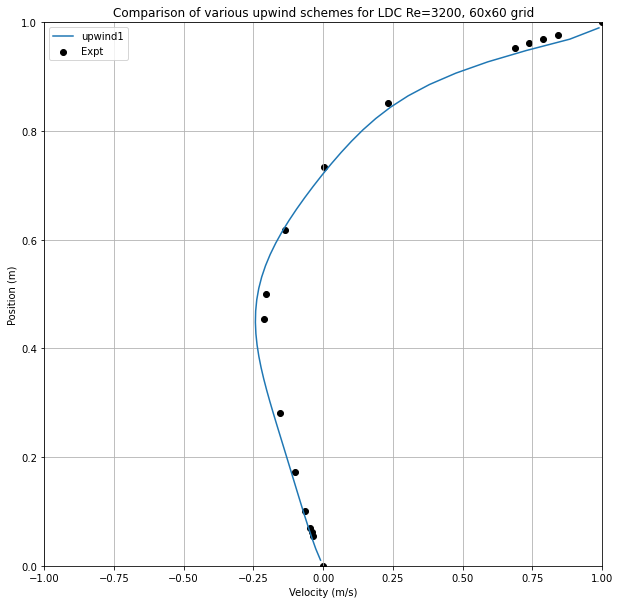

In [107]:
mid=(column(U_final,23)+column(U_final,24))/2
y=np.linspace(dy/2,H-dy/2,Ny)
y40=np.linspace(1/80,H-1/80,40)
y60=np.linspace(1/120,H-1/120,60)

fig,ax=plt.subplots(1,1,figsize=(10,10))
#plt.plot(upwind1/3.2,y,label='Upwind1')
#plt.plot(TVD2/3.2,y,label='TVD2')
plt.plot(mid/0.1,y,label='upwind1')
#plt.plot(QUICK3,y,label='3rd order QUICK',linestyle='dashed',linewidth=3,color='r',dashes=(4,6))
plt.scatter(mid_expt_100,mid_expt_y,color='k',label='Expt')
plt.title('Comparison of various upwind schemes for LDC Re=3200, 60x60 grid')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Position (m)')
plt.xlim(-1,1)
plt.ylim(0,H)
plt.grid()
plt.legend()
plt.show()

In [29]:
np.save('RE5000_LDC_reversal_U.npy',U_time_data)
np.save('RE5000_LDC_reversal_V.npy',V_time_data)
np.save('RE5000_LDC_reversal_P.npy',P_final)

# <font color='blue'>Animation</font>

In [22]:
U_anim=U_time_data[::]
V_anim=V_time_data[::]
count=600

U_file=[]
V_file=[]
V_mag_file=[]
Vort_file=[]

for k in range(count):
    U_final=U_anim[k]
    V_final=V_anim[k]
            
    V_mag=np.sqrt(np.power(U_final,2))+np.sqrt(np.power(V_final,2))           
    vort=curl(U_final,V_final,dx,dy,Nx,Ny)
            
    U_file.append(U_final)
    V_file.append(V_final)
    V_mag_file.append(V_mag)
    Vort_file.append(vort)

In [53]:
def animate(k):
    ax.clear()
    
    U_final=U_file[k]
    V_final=V_file[k]
    #V_mag=V_mag_file[k]
    #vort=Vort_file[k]
    plt.title('Flow time: '+str(round(k*dt*20,3))+' seconds \n' 'Streamlines')
    #plt.title('Velocity')
    plt.xlim(0,L)
    plt.ylim(0,H)
    #rect1=patches.Rectangle([0.5,0.4],0.2,0.2,hatch='////',fc='k',ec='k')
    #ax.add_patch(rect1)
    #contour=plt.contourf(xx,yy,V_mag,cmap=cm.jet,vmax=5,levels=255)
    #contour=plt.contourf(xx,yy,vort,cmap=cm.seismic,levels=255,vmax=45,vmin=-45)
    stream=plt.streamplot(xx,yy,U_final,V_final,linewidth=0.75,density=3,color='k',arrowsize=0)
    return stream

<IPython.core.display.Javascript object>


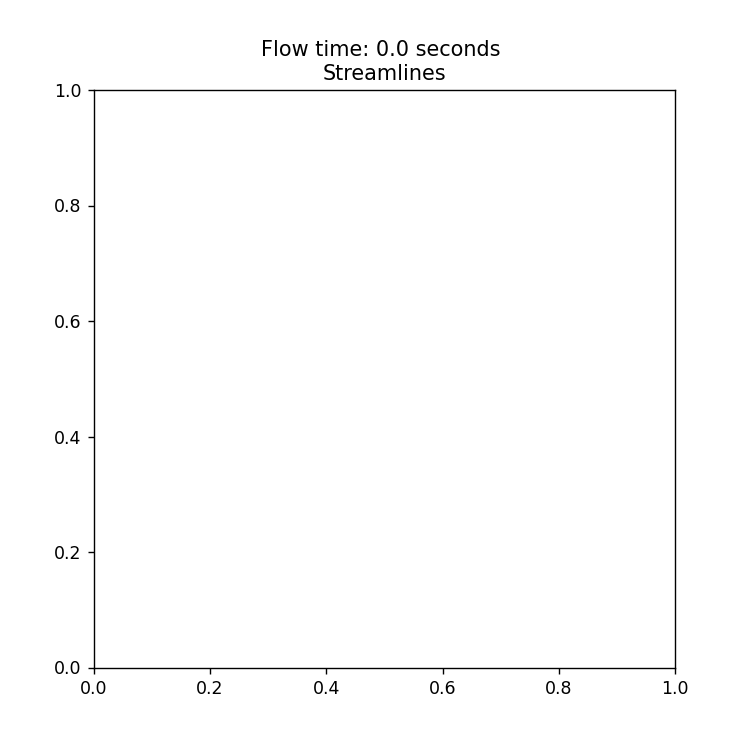

In [54]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
plt.xlim(0,L)
plt.ylim(0,H)
x=np.linspace(0,L,Nx)
y=np.linspace(0,H,Ny)
xx,yy=np.meshgrid(x,y)

ani=FuncAnimation(fig,animate,count,interval=2000, blit=True)
plt.show()

In [ ]:
print('Help')